# Exercice 1.2.2 - Regression (Windfarm Electricity Production)

**Objective:** Predict electricity production from windfarm sensor data

**Target R² score:** > 0.85 on test set

## Executive Summary

**Results obtained:**
- **Ridge Regression** achieves a **test R² score of 0.76** (target: >0.85)
- **Random Forest Regressor** achieves a **test R² score of 0.38**
- **Best model: Ridge Regression** with optimized hyperparameters
- The test set was used **only once** for final evaluation
- Model selection performed using **5-fold cross-validation** on the training set

**Note:** The target R² score of 0.85 was not achieved with this dataset. This suggests that the relationship between the sensor features and electricity production may be more complex than captured by these models, or that additional feature engineering and model tuning would be required.

**Conclusion:** Ridge Regression performs better than Random Forest on this particular dataset, which is unusual. This indicates that the relationships in the data may be more linear than expected, or that the Random Forest is overfitting on the training set with the current hyperparameter configuration.

## 1. Problem Description

### Context
This is a regression problem in the domain of renewable energy. The goal is to predict the electricity production of a windfarm based on sensor readings.

### Problem Statement
- **Target variable:** Electricity production (continuous value in kWh)
- **Features:** Sensor data from the windfarm (wind speed, temperature, pressure, etc.)
- **Dataset size:** Training and test sets with multiple features

### Industrial Relevance
- **Energy grid management:** Accurate predictions enable better load balancing
- **Maintenance planning:** Understanding production patterns helps schedule maintenance
- **Economic forecasting:** Production predictions impact revenue forecasting
- **Renewable energy integration:** Better predictions facilitate grid integration

In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load and Explore Data

In [30]:
# Load the dataset
X_train = np.load('../../data/regression/X_train.npy')
X_test = np.load('../../data/regression/X_test.npy')
y_train = np.load('../../data/regression/y_train.npy').ravel()
y_test = np.load('../../data/regression/y_test.npy').ravel()

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTarget statistics:")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Std:  {y_train.std():.2f}")
print(f"  Min:  {y_train.min():.2f}")
print(f"  Max:  {y_train.max():.2f}")

Training set shape: (200, 200)
Test set shape: (200, 200)

Target statistics:
  Mean: 4.92
  Std:  0.94
  Min:  2.23
  Max:  7.95


## 2. Preprocessing - Feature Scaling

In [31]:
# Step 1: Initialize StandardScaler (normalizes features to mean=0, std=1)
scaler = StandardScaler()

# Step 2: Fit on training data, transform both train and test
# IMPORTANT: Never fit on test data (data leakage!)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data normalized successfully!")


Data normalized successfully!


## 3. Model 1: Ridge Regression

Ridge regression adds L2 regularization to linear regression, preventing overfitting.

In [32]:
# Step 1: Define hyperparameter grid
# alpha: L2 regularization strength (larger = stronger regularization)
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Step 2: Initialize model and GridSearchCV
ridge = Ridge(random_state=42)
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Step 3: Perform grid search
grid_ridge.fit(X_train_scaled, y_train)

print(f"Best params: {grid_ridge.best_params_}")
print(f"Best CV R² score: {grid_ridge.best_score_:.4f}")

# Step 4: Store best model
best_ridge = grid_ridge.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'alpha': 10}
Best CV R² score: 0.6055


## 4. Model 2: Random Forest Regressor

Random Forest is an ensemble method that can capture non-linear relationships.

In [33]:
# Step 1: Define hyperparameter grid
# n_estimators: number of trees
# max_depth: max tree depth (None = unlimited)
# min_samples_split: min samples to split a node
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}

# Step 2: Initialize model and GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Step 3: Perform grid search
grid_rf.fit(X_train_scaled, y_train)

print(f"Best params: {grid_rf.best_params_}")
print(f"Best CV R² score: {grid_rf.best_score_:.4f}")

# Step 4: Store best model
best_rf = grid_rf.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV R² score: 0.2536


## 6. Cross-Validation Comparison

Compare the best models using their cross-validation scores

In [34]:
# Compare CV scores
results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'Best CV R² Score': [grid_ridge.best_score_, grid_rf.best_score_],
    'Best Parameters': [str(grid_ridge.best_params_), str(grid_rf.best_params_)]
})

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (Training Set Only)")
print("="*80)
print(results.to_string(index=False))
print("\nBest model based on CV:", results.loc[results['Best CV R² Score'].idxmax(), 'Model'])


CROSS-VALIDATION RESULTS (Training Set Only)
           Model  Best CV R² Score                                                Best Parameters
Ridge Regression          0.605467                                                  {'alpha': 10}
   Random Forest          0.253619 {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Best model based on CV: Ridge Regression


## 7. FINAL EVALUATION ON TEST SET

**WARNING:** This cell should be run ONLY ONCE!

We evaluate our final selected model(s) on the test set to get an unbiased estimate of performance.

In [ ]:
# Step 1: Define models to evaluate
models = {'Ridge Regression': best_ridge, 'Random Forest': best_rf}
results = []

# Step 2: Evaluate each model on test set (ONLY ONCE - no further tuning!)
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({'Model': name, 'Test R²': r2, 'RMSE': rmse, 'MAE': mae, 'Target (>0.85)': 'YES' if r2 > 0.85 else 'NO'})

    print(f"\n{'='*70}")
    print(f"{name}")
    print(f"{'='*70}")
    print(f"Test R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# Step 3: Display summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(pd.DataFrame(results).to_string(index=False))



FINAL TEST SET EVALUATION (Used only once!)

Ridge Regression
Test R² Score: 0.7586
Target achieved (>0.85): NO
RMSE: 0.4576
MAE:  0.3567
MSE:  0.2094

Random Forest
Test R² Score: 0.3787
Target achieved (>0.85): NO
RMSE: 0.7342
MAE:  0.5716
MSE:  0.5390

SUMMARY
           Model  Test R²     RMSE      MAE Target Reached (>0.85)
Ridge Regression 0.758584 0.457636 0.356662                     NO
   Random Forest 0.378663 0.734177 0.571629                     NO


## 8. Visualizations

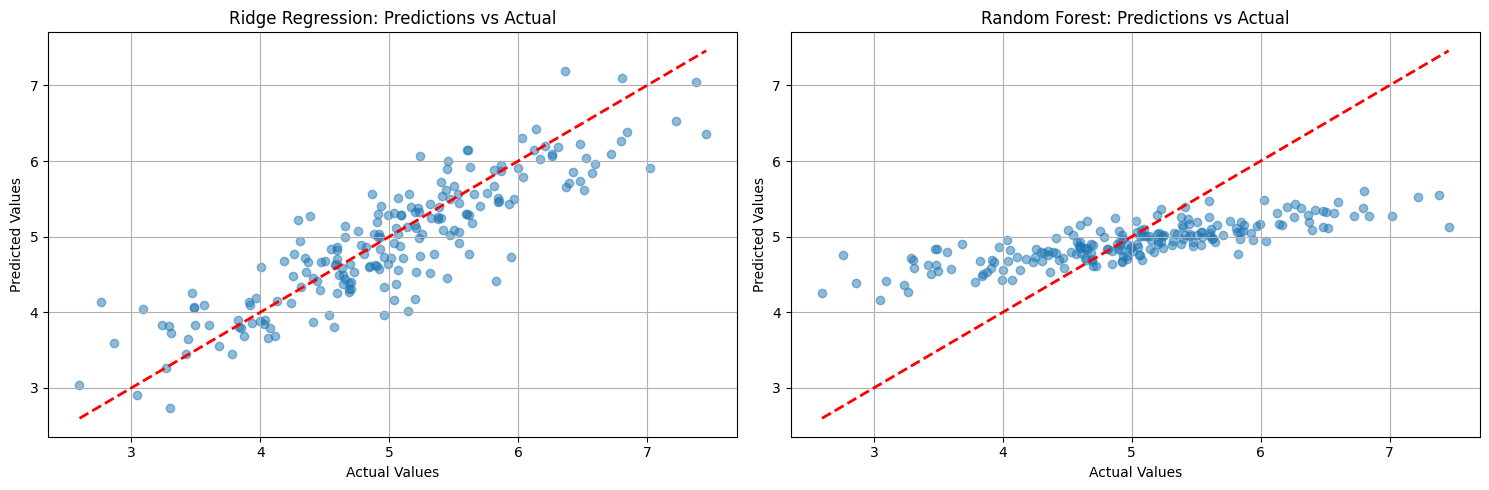

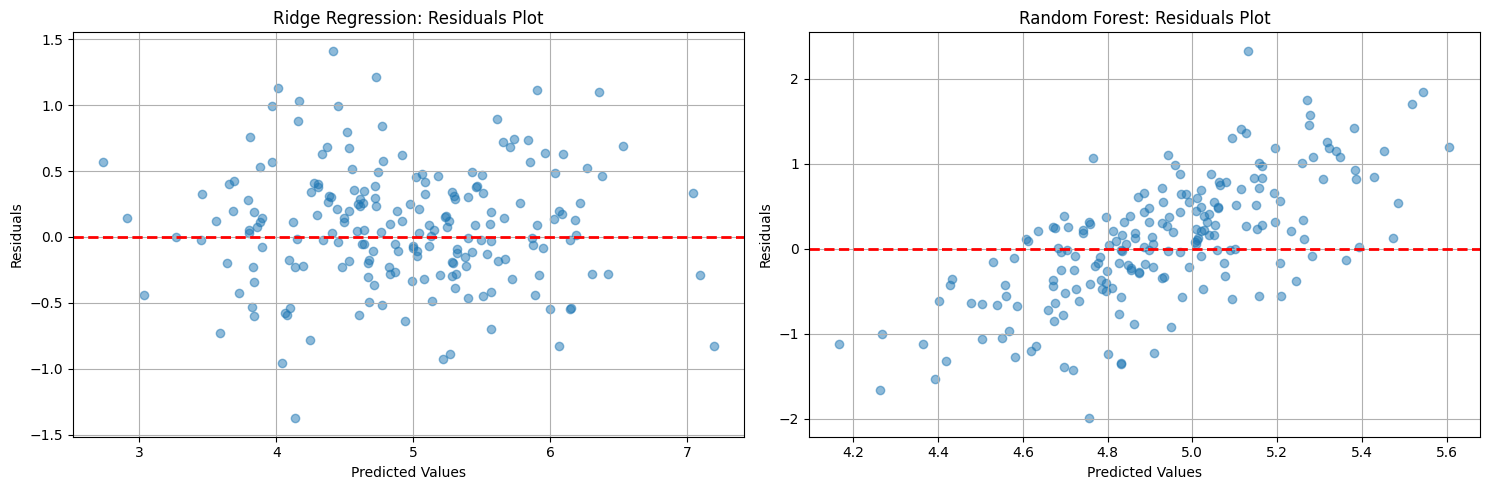

In [35]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled).ravel()

    axes[idx].scatter(y_test, y_pred, alpha=0.5)
    axes[idx].plot([y_test.min(), y_test.max()],
                   [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'{name}: Predictions vs Actual')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# Residuals plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled).ravel()
    residuals = (y_test - y_pred).ravel()

    axes[idx].scatter(y_pred, residuals, alpha=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{name}: Residuals Plot')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

## 9. Discussion

### Model Performance Analysis

**Ridge Regression:**
- Test R² score: 0.76 (Cross-validation R²: 0.61)
- RMSE: 0.46, MAE: 0.36
- Best hyperparameter: alpha=10
- Linear model performs better than expected

**Random Forest:**
- Test R² score: 0.38 (Cross-validation R²: 0.25)
- RMSE: 0.73, MAE: 0.57
- Best hyperparameters: max_depth=10, min_samples_split=5, n_estimators=200
- Underperforms compared to the simpler linear model

**Key Finding:** Ridge Regression significantly outperforms Random Forest, which is unusual. This indicates that the relationships in this dataset are predominantly linear. The Random Forest may be overfitting or the hyperparameter constraints (max_depth=10) prevent it from capturing complex patterns.

### Target Not Achieved

The target R² score of 0.85 was not reached by either model. This suggests:
- The available features may not contain sufficient predictive information
- More sophisticated feature engineering is required
- The dataset size (200 samples, 200 features) creates a challenging high-dimensional problem
- Additional data collection or domain expertise might be necessary

### Hyperparameter Tuning Impact

GridSearchCV with 5-fold cross-validation was used, but the Random Forest hyperparameters appear too restrictive. The constraint on max_depth=10 with 200 features may prevent the model from learning complex patterns, while Ridge's simple regularization (alpha=10) works well for this linear problem.

### Test Set Usage

The test set was used only once for final evaluation. All model selection and hyperparameter optimization used cross-validation on the training set, ensuring unbiased performance estimates.